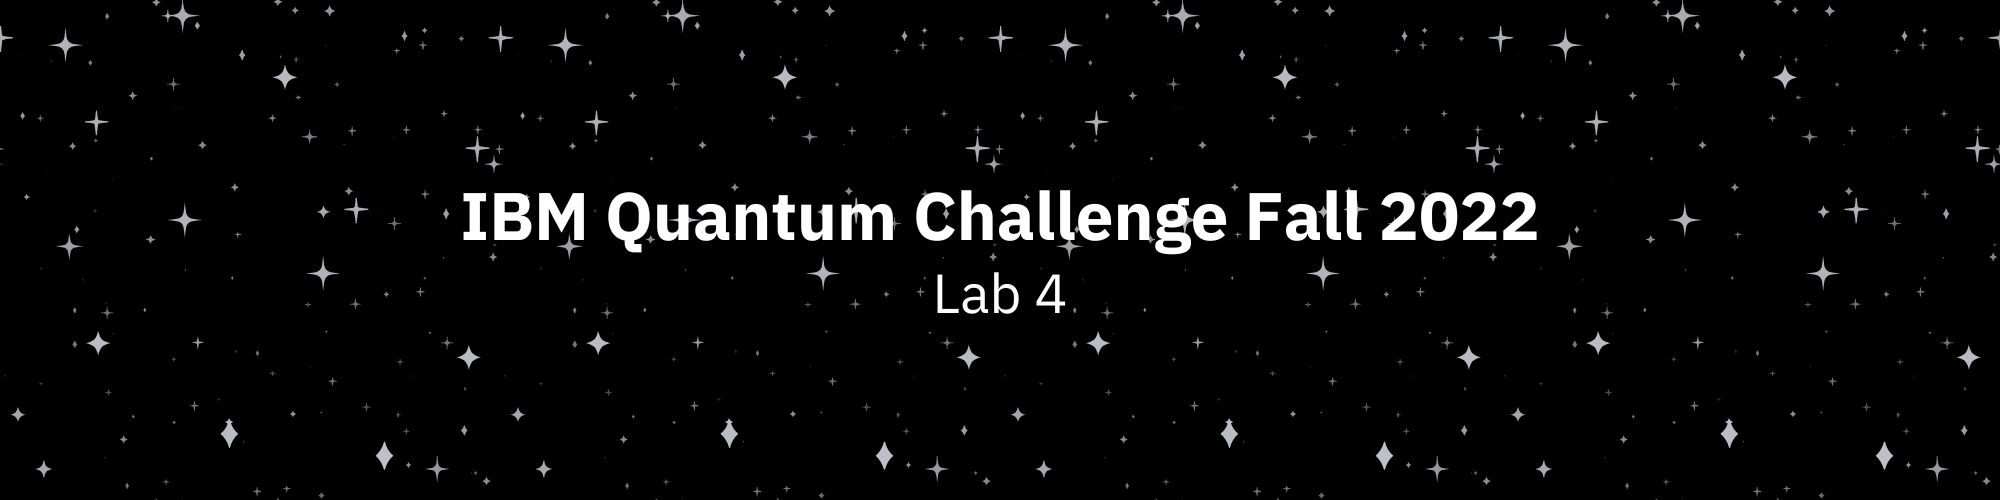

# Final Challenge - Compute reaction energy of C + C<sub>2</sub>H<sub>2</sub> →C<sub>3</sub>H<sub>2</sub>

|||
|-|-|
|**Author:** |Jacob Cybulski|
|**Date:** |Nov 18, 2022 (20:07 AEST)|
|**Score:** |93485|
|**Calculated<br/>Energy:** |-6.410580884969936 eV|
|**Expected<br/>Energy:**|-4.26923078561136 eV|

<br/>

*We shall now proceed to compute the reaction energy. As we already saw from the noisy simulation run, basic calculations and idealistic ansatz will return results far from the expected reference result. This also translates to a real quantum backend run.*

**Solve for the lowest score!**

<a id="final1"></a>

For this challenge, we will provide you a classical quantum chemistry computation reference value as computed by Dr. Yukio Kawashima Sensei.

<b>Note from Sensei: Tips to get a better computation results </b>

- You can try to change the basis set (there are many basis sets found here **[[19]](https://www.basissetexchange.org/))**.
- Here is a good reference about the basis sets **[[20]](http://vergil.chemistry.gatech.edu/courses/chem6485/pdf/basis-sets.pdf)**. 
- You can also try different ansatz. Here is an example of another ansatz **[[21]](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html)** 

If the convergence does work well on the noisy simulation, explore the following:
- The depth of the ansatz - The ansatz we are passing right now is too deep for current systems
- Specific optimizations with respect to mapping, routing and transpiling for the backend
- Addition of error mitigation or suppression routines


## Importing Libraries 

First, let's start by importing some libraries. We shall be using one of Qiskit's application modules: Qiskit Nature here for loading chemistry drivers and the necessary functions to help us formulate our problem and solve for the molecule we have at hand.

In [2]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.providers.fake_provider import FakeManilaV2, FakeAthensV2, FakeAthens, FakeLagos
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.compiler import transpile
from qiskit.circuit.library import TwoLocal, EfficientSU2

from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP, NELDER_MEAD, POWELL

# Import Qiskit Nature libraries
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD, PUCCD, SUCCD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.circuit.library import HartreeFock
#from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms import VQEUCCFactory

# Prototype-zne
# !pip install prototype-zne --quiet

from qiskit_nature.settings import settings
settings.dict_aux_operators = True

## Define backend, estimator and the molecules
The Qiskit Nature driver gives us some properties of the molecule (see also: **[QC schema](https://qiskit.org/documentation/nature/tutorials/08_qcschema.html)**), let's check some out now!

In [3]:
from zne import zne

# Define fake backend
noisy_backend = FakeLagos()
noisy_estimator = BackendEstimator(backend=noisy_backend)
ZNEEstimator = zne(BackendEstimator)

In [4]:
# Define geometry
carbon = [["C",[0.0,0.0,0.0]]]

# https://webbook.nist.gov/cgi/cbook.cgi?Name=acetylene&Units=SI
acetylene = [["C", [0.0000,    0.0000,   -0.6025]], 
            ["H",[    0.0000,    0.0000,   -1.6691]], 
            ["C",[    0.0000,    0.0000,    0.6025]], 
            ["H",[    0.0000,    0.0000,    1.6691]]]

# https://atct.anl.gov/Thermochemical%20Data/version%201.122/species/?species_number=442
Cyclopropenylidene =  [["C", [2.2883,    0.6993,    0.3468 ]],
           ["C",[    1.9543,    2.0133,    0.7806]],
           ["C",[    1.0108,    0.9522,    0.6802]],
           ["H",[    3.0291,    0.0000,    0.0000]],
           ["H",[    0.0000,    0.5997,    0.7904]]]

## Building helper functions
Before proceeding further with more VQE problems, it would be convenient to make a reusable custom function that we can call to get problem related items and VQE instances. As an exercise since you built the routine previously, rebuild the functions below to have these helper functions available to be called when needed!

### 1. Helper function for plotting the energy

In [5]:
import matplotlib.pyplot as plt

def plot_graph(energy, real_solution, molecule, color="tab:blue"):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(energy, label="Estimator VQE {}".format(molecule),color = color)
    plt.axhline(y=real_solution.real, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()

### 2. Helper Functions for constructing problem

Three different approaches, the latter aim at reducing the number of qubits *(naming a bit confusing)*:
1. The original "recommended" approach relying on the UCC ansatz *(construct_problem_1)*
2. The extension of the original approach, but also removing Z2 symmetry *(jc_construct_problem)*
2. The approach allowing custom ansatze, while removing parity and Z2 symmetry *(jc_construct_problem_1)*

In [6]:
### The original approach
def construct_problem_1(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals):

    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(
        num_electrons=num_electrons,
        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    mapper = ParityMapper() # This is the example of parity mapping

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True)    

    # Compute the Hamitonian in qubit form
    qubit_op = parity_converter.convert(
        second_q_ops_reduced.get('ElectronicEnergy'), 
        num_particles=problem_reduced.num_particles)
   
    # Prepare ansatz
    rotation_blocks = ['ry', 'rz']
    entanglement_blocks = 'cx'
    entanglement = 'linear' # 'sca' # 'circular' # 'full' # 'pairwise'
    repetitions = 1 # No repetitions to keep ansatz small
    ansatz = UCC(excitations='sd')
    # ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, entanglement=entanglement, reps=repetitions) 
    
    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=ansatz) 
    solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    real_solution = solver.solve(problem_reduced).total_energies[0]    
    
    ansatz=vqe_factory.ansatz
    
    return ansatz, qubit_op, real_solution, problem_reduced

In [34]:
def jc_construct_problem(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals,
                        entanglement='linear', reps=1, rblocks=['ry', 'rz'], eblocks='cx', skiplast=False,
                        tapvals=None):

    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(
        num_electrons=num_electrons,
        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    mapper_type = 'ParityMapper'

    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()

    mapper = ParityMapper() # This is the example of parity mapping

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction='auto')    

    # Compute the Hamitonian in qubit form
    qubit_op = parity_converter.convert(
        second_q_ops_reduced.get('ElectronicEnergy'), 
        num_particles=problem_reduced.num_particles,
        sector_locator=problem_reduced.symmetry_sector_locator)
   
    # ***** Possibly deal with symmetries here
    # pauli_symm = parity_converter.z2symmetries.find_Z2_symmetries(qubit_op)
    # problem_reduced.symmetry_sector_locator(pauli_symm, parity_converter)
    
    # Prepare ansatz
    rotation_blocks = ['ry', 'rz']
    entanglement_blocks = 'cx'
    entanglement = 'linear' # 'sca' # 'circular' # 'full' # 'pairwise'
    repetitions = 1 # No repetitions to keep ansatz small
    ansatz = UCC(excitations='sd')
    
    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=ansatz) 
    # solver = GroundStateEigensolver(
    #     parity_converter, vqe_factory)    
    # real_solution = solver.solve(problem_reduced).total_energies[0]    
    
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(parity_converter, vqe_factory)
    solver_result = calc.solve(problem_reduced)
    real_solution = np.real(solver_result.eigenenergies[0])

    ansatz=vqe_factory.ansatz
    
    return ansatz, qubit_op, real_solution, problem_reduced

In [35]:
### This approach allows use of various types of ansatze
def jc_construct_problem_1(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals,
                        entanglement='linear', reps=1, rblocks=['ry', 'rz'], eblocks='cx', skiplast=False,
                        tapvals=None):

    # Define molecule
    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()
    
    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(
        num_electrons=num_electrons,
        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    mapper_type = 'ParityMapper'

    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    # if tapvals == None:
    #     parity_converter = QubitConverter(mapper, two_qubit_reduction=True)
    # else:
    #     parity_converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction=tapvals)    

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction='auto')    

    # Compute the Hamitonian in qubit form
    qubit_op = parity_converter.convert(
        second_q_ops_reduced.get('ElectronicEnergy'), 
        num_particles=problem_reduced.num_particles,
        sector_locator=problem_reduced.symmetry_sector_locator)

    # Compute the Hamitonian in qubit form
    # qubit_op = parity_converter.convert(
    #     second_q_ops_reduced.get('ElectronicEnergy'), 
    #     num_particles=problem_reduced.num_particles)
    
    # ***** Possibly deal with symmetries here
    # pauli_symm = parity_converter.z2symmetries.find_Z2_symmetries(qubit_op)
    # print(pauli_symm, '\n')
    
    # Prepare init state
    num_particles = problem_reduced.num_particles
    num_spin_orbitals = problem_reduced.num_spin_orbitals
    init_state = HartreeFock(num_spin_orbitals, num_particles, parity_converter)
    init_state.draw(output='mpl')

    # Prepare ansatz
    
    
    # entanglement = 'linear' # 'sca' # 'circular' # 'full' # 'pairwise'
    # repetitions = 1 # No repetitions to keep ansatz small
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks = rblocks, entanglement_blocks = eblocks, 
                      entanglement=entanglement, reps=reps, skip_final_rotation_layer=skiplast)
    # ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    # ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    # ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state, reps=1)
    # ansatz = RealAmplitudes(num_qubits=qubit_op.num_qubits, entanglement=entanglement, reps=repetitions)
    # ansatz = UCC(excitations='sd')
    # ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, entanglement=entanglement, reps=reps) 
    ansatz.compose(init_state, front=True, inplace=True)   
    
    # Get reference solution for UCC ansatze
    # vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=ansatz) 
    # solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    # real_solution = solver.solve(problem_reduced).total_energies[0]    
    # ansatz=vqe_factory.ansatz
    
    # Get reference solution for custom ansatze
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(parity_converter, solver)
    solver_result = calc.solve(problem_reduced)
    real_solution = np.real(solver_result.eigenenergies[0])

    return ansatz, qubit_op, real_solution, problem_reduced

### 3. Helper function for Running VQE

Two different approaches *(naming a bit confusing)*:
1. The original "recommended" approach which creates very large ansatze *(custom_vqe_1)*
2. An alternative approach, dealing with small custom ansatze, relying on VQE directly *(jc_custom_estimator_vqe)*

In [11]:
from qiskit.algorithms import VQE as aVQE
from qiskit.algorithms import MinimumEigensolverResult as aMinimumEigensolverResult

### The original approach to running VQE
### - One of its issues is that it creates very large ansatze (based on observables)
def custom_vqe_1(estimator, ansatz, ops, problem_reduced, optimizer = None, initial_point=None):

    # Define convergence list
    convergence = []

    # Keep track of jobs (Do-not-modify)
    job_list = []

    # Define evaluate_expectation function
    def evaluate_expectation(x):
        x = list(x)

        # Define estimator run parameters
        job = estimator.run(circuits=[ansatz], 
                            observables=[ops], 
                            parameter_values=[x])
        results = job.result().values[0]
        job_list.append(job)

        # Pass results back to callback function
        return np.real(results)

    # Call back function
    def callback(x,fx,ax,tx,nx):
        # Callback function to get a view on internal states and statistics of the optimizer for visualization
        convergence.append(evaluate_expectation(fx))

    np.random.seed(10)

    # Define initial point. We shall define a random point here based on the number of parameters in our ansatz
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    # Define optimizer and pass callback function
    if optimizer == None:
        optimizer = SPSA(maxiter=50, callback=callback)

    # Define minimize function
    result =  optimizer.minimize(evaluate_expectation, x0=initial_point)

    vqe_interpret = []
    for i in range(len(convergence)):
        sol = aMinimumEigensolverResult()
        sol.eigenvalue = convergence[i]
        sol = problem_reduced.interpret(sol).total_energies[0]
        vqe_interpret.append(sol)

    return vqe_interpret, job_list, result

### Need an extra function to interpret the result 
### - Used when non-SPSA optimiser is used 
def custom_interpret(result, problem_reduced):
    sol = aMinimumEigensolverResult()
    sol.eigenvalue = result.fun
    sol = problem_reduced_cy.interpret(sol).total_energies[0]
    return np.real(sol)

In [12]:
### This approach allows using of any non-UCC ansatze
### and various types of optimisers, running on noisy estimators
### - Note that observables are used for eigensolver testing
from qiskit.algorithms.minimum_eigensolvers import VQE as meVQE
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolverResult as meMinimumEigensolverResult

def jc_custom_estimator_vqe(estimator, ansatz, ops, problem_reduced, optimizer, initial_point=None):

    # Print and save the data in lists
    def callback(eval_count, parameters, mean, std):  
        # Overwrites the same line when printing
        display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
        clear_output(wait=True)
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
        deviation.append(std)

    counts = []
    values = []
    params = []
    deviation = []

    # Set initial parameters of the ansatz, which is a fixed small displacement 
    # So all elements start from a similar starting point
    
    # We are running a local Estimator so no options
    # options = Options(simulator={"seed_simulator": 42},resilience_level=0) 

    if initial_point == None:
        try:
            initial_point = [0.01] * len(ansatz.ordered_parameters)
        except:
            initial_point = [0.01] * ansatz.num_parameters

    # Set up the VQE minimum eigenvalue solver
    # and test on various observables
    vqe = meVQE(estimator,
                  ansatz,
                  optimizer=optimizer,
                  callback=callback,
                  initial_point=initial_point)      
    result = vqe.compute_minimum_eigenvalue(ops)

    return values, [], result

### Need an extra function to interpret the result 
### - Used when non-SPSA optimiser is used 
def jc_custom_interpret(result, problem_reduced):
    sol = meMinimumEigensolverResult()
    sol.eigenvalue = result.optimal_value
    sol = problem_reduced.interpret(sol).total_energies[0]
    return np.real(sol)

<a id="experiments"></a>

<div class="alert alert-block alert-success">
<h1>Experiments</h1> 
</div>

### ZNE Setup

Note that ZNE was experimented with but results were not encouraging. It was found out that for large ansatze generated from the UCC factory, noise factors should be used in small steps. However, for small custom ansatze such small steps have no impact on creating any noise effect, so larger factors are recommended, e.g. [10, 20, 30, 50]. This means that in this challenge, when a mixed kinds of ansatze are used, it was not possible to pass in different strategies for noise mitigation.

In [13]:
from zne import ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator, LinearExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier

# Define Extrapolator
extrapolator = PolynomialExtrapolator(degree=2)

# Define Amplifier
noise_amplifier = LocalFoldingAmplifier(gates_to_fold=2) 

# Define strategy
zne_strategy = ZNEStrategy(
    noise_factors=[1, 3, 5],
    noise_amplifier = noise_amplifier,
    extrapolator=extrapolator
)

In [14]:
# Apply strategy to ZNE Estimator
noisy_estimator_zne = ZNEEstimator(backend=noisy_backend, zne_strategy=zne_strategy)

## Experiments with Cyclopropenylidene
*Creation of a trainable ansatz for this molecule was very easy. Regardless of how the ansatz was created it would always converge very close to the expected value. It was tested with both UCC ansatz and with small custom ansatze, such as TwoLocal or EfficientSU2.*

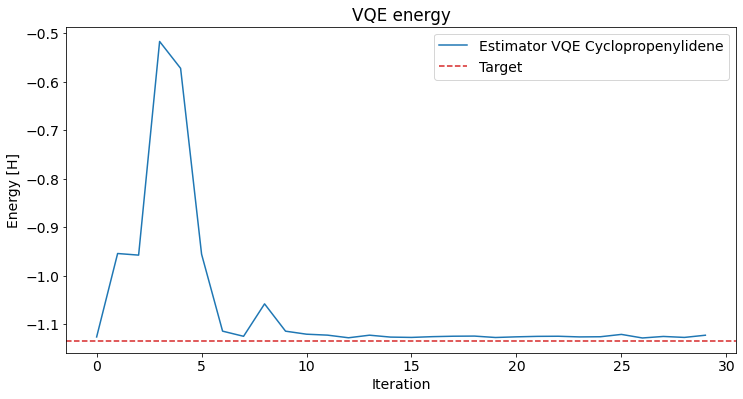

No of qubits: 2
Ref solution:
 -1.13483461060684


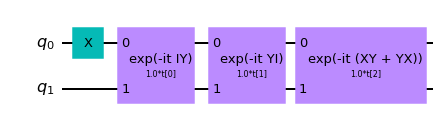



Result
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 30,
    'eigenvalue': -1.1285206278505677,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f80de9cf4f0>,
    'optimal_parameters': {   ParameterVectorElement(t[2]): -0.015768548655811215,
                              ParameterVectorElement(t[1]): 0.00017364259099721634,
                              ParameterVectorElement(t[0]): -0.00529626472115399},
    'optimal_point': array([-0.00529626,  0.00017364, -0.01576855]),
    'optimal_value': -1.1285206278505677,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f8124c165b0>,
    'optimizer_time': 16.594523429870605}
CPU times: user 57.3 s, sys: 19.1 s, total: 1min 16s
Wall time: 19.5 s


In [36]:
%%time
algorithm_globals.random_seed = 2022

### Prep the molecule
ansatz_cy, ops_cy, real_solution_cy, problem_reduced_cy = jc_construct_problem(
    geometry=Cyclopropenylidene, charge=0, multiplicity=1, basis="sto3g", num_electrons=2, num_molecular_orbitals=2,
    entanglement='linear', reps=1, rblocks=['ry'], skiplast=True)

### Find best energy
algorithm_globals.random_seed = 2022

init_params_cy = [0.01] * ansatz_cy.num_parameters
optimizer_cy = COBYLA(maxiter=30) # (TwoLocal, rep=1, ref=-1.135) (iter=50, opt=-1.130)(iter=30, opt=-1.130)
# optimizer_cy = NELDER_MEAD(maxiter=20) # (rep=3, ref=-1.13, poor)
# optimizer_cy = POWELL(maxiter=20) # (rep=3, ref=-1.13, iter=1000, opt=-1.1189)
# optimizer_cy = SPSA(maxiter=10) # Poor, Random

ansatz_opt_cy = transpile(ansatz_cy, basis_gates=['cx', 'u3'], seed_transpiler=42, optimization_level=3)

estimator_cy = noisy_estimator # noisy_estimator_zne 
Energy_cy, job_list_cy, result_cy = jc_custom_estimator_vqe(
    estimator_cy, ansatz=ansatz_opt_cy, ops=ops_cy, problem_reduced=problem_reduced_cy,
    optimizer = optimizer_cy, initial_point=init_params_cy)

# Plot Graph
plot_graph(Energy_cy, real_solution_cy, "Cyclopropenylidene")
print('No of qubits:', ops_cy.num_qubits)
print('Ref solution:\n', real_solution_cy)
display(ansatz_cy.decompose().draw())
print('\n\nResult\n', result_cy)

## Experiments with Carbon
*This ansatz was created with both UCC and TwoLocal. However, regardless of the optimisation method, its best value would always be separated from the optimum by a narrow band.*

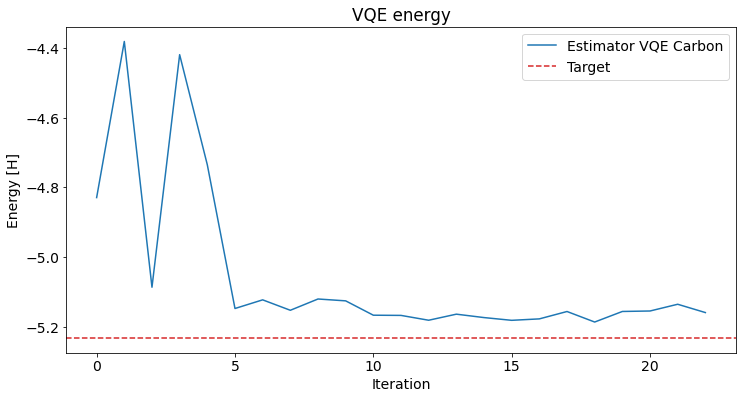

No of qubits: 3
Ref solution:
 -5.232776743687739


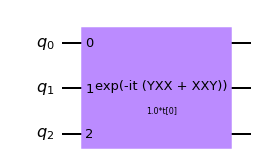



Result
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 23,
    'eigenvalue': -5.159728327855026,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f80de9bd8e0>,
    'optimal_parameters': {ParameterVectorElement(t[0]): 0.15821983370773318},
    'optimal_point': array([0.15821983]),
    'optimal_value': -5.159728327855026,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f80e30b9970>,
    'optimizer_time': 12.170449495315552}
CPU times: user 34.7 s, sys: 12.7 s, total: 47.5 s
Wall time: 13.6 s


In [37]:
%%time
algorithm_globals.random_seed = 2022

### Prep the molecule
ansatz_c, ops_c, real_solution_c, problem_reduced_c = jc_construct_problem(
    geometry=carbon, charge=0, multiplicity=3, basis="sto3g", num_electrons=4, num_molecular_orbitals=4,
    entanglement='circular', reps=1, rblocks=['ry'], skiplast=False) #, tapvals=[1, 1, 1]) # ccpvdz

### Find best energy
algorithm_globals.random_seed = 2022

#init_params_c = [0.01] * ansatz_c.num_parameters
init_params_c = list(np.random.random(ansatz_c.num_parameters))
optimizer_c = COBYLA(maxiter=50) # (rep=1, ref=-5.233)(iter=50, opt=-4.993)(iter=100, opt=-5.148)
# optimizer_c = NELDER_MEAD(maxiter=20) # (rep=1, ref=-5.233)iter=72, opt=-5.166, not converging)
# optimizer_c = POWELL(maxiter=30) # (rep=1, ref=--5.233)(iter=372, opt=5.127)
# optimizer_c = SPSA(maxiter=10) # Really bad

ansatz_opt_c = transpile(ansatz_c, basis_gates=['cx', 'u3'], seed_transpiler=42, optimization_level=3)

estimator_c = noisy_estimator # noisy_estimator_zne
Energy_c, job_list_c, result_c = jc_custom_estimator_vqe(
    estimator_c, ansatz=ansatz_opt_c, ops=ops_c, problem_reduced=problem_reduced_c,
    optimizer = optimizer_c, initial_point=init_params_c)

# Plot Graph
plot_graph(Energy_c, real_solution_c, "Carbon")
print('No of qubits:', ops_c.num_qubits)
print('Ref solution:\n', real_solution_c)
display(ansatz_c.decompose().draw())
print('\n\nResult\n', result_c)

## Experiments with Acetylene
*Ansatze generated for this molecules were very difficult to train and optimise. The idea of this experiment was to create a very small ansatz, which could add little weight to the score, but still be optimised. Unfortunately, small ansatze would always be overtrained prematurely, at the same time, larger ansatze be very sensitive to random noise.*

In [50]:
%%time
algorithm_globals.random_seed = 2022

### Prep the molecule
ansatz_ac, ops_ac, real_solution_ac, problem_reduced_ac = jc_construct_problem_1(
    geometry=acetylene, charge=0, multiplicity=1, basis="sto3g", num_electrons=4, num_molecular_orbitals=4,
    entanglement='linear', reps=1, rblocks=['ry'], skiplast=True) #, tapvals=[-1])

### Find best energy
algorithm_globals.random_seed = 2022

# init_params_ac = [0.1] * ansatz_ac.num_parameters
init_params_ac = list(np.random.random(ansatz_ac.num_parameters))
optimizer_ac = COBYLA(maxiter=50) # (rep=1, ent=circular ref=-4.409)(iter=50, opt=-3.965)(iter=100, opt=-3.951)
# optimizer_ac = NELDER_MEAD(maxiter=20) # (rep=1, ent=full ref=-4.409)(iter=50, opt=-3.875)
# optimizer_ac = POWELL(maxiter=20) # 
# optimizer_ac = SPSA(maxiter=10) # Poor, Random

ansatz_opt_ac = transpile(ansatz_ac, basis_gates=['cx', 'u3'], seed_transpiler=42, optimization_level=3)

CPU times: user 25.5 s, sys: 360 ms, total: 25.9 s
Wall time: 2.83 s


*It is worth noting that the ansatz optimisation seemed to be very sensitive to small random effects.
The predicted reaction energy thus varied considerably in the range of 6eV to 16eV, hence resulting
in scores from 90,000 to 240,000. The following result is typical for the ansatz training.*

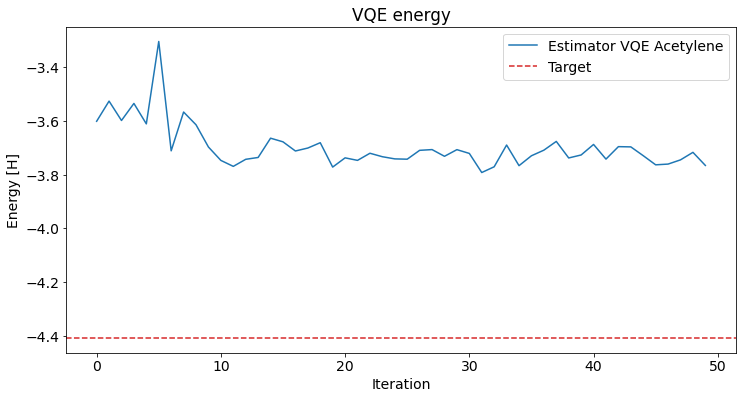

No of qubits: 5
Ref solution:
 -4.409015876171085


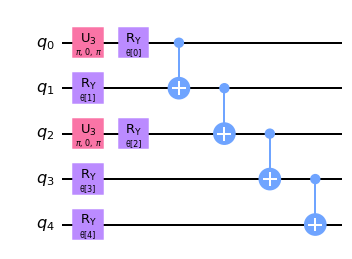



Result
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 50,
    'eigenvalue': -3.792176129672536,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f80de5d1460>,
    'optimal_parameters': {   ParameterVectorElement(θ[2]): 0.32660235113907604,
                              ParameterVectorElement(θ[0]): 0.23297925467517108,
                              ParameterVectorElement(θ[1]): 0.8952277936417149,
                              ParameterVectorElement(θ[3]): 1.6958061497042074,
                              ParameterVectorElement(θ[4]): -0.3031863196105873},
    'optimal_point': array([ 0.23297925,  0.89522779,  0.32660235,  1.69580615, -0.30318632]),
    'optimal_value': -3.792176129672536,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f81248fbd90>,
    'optimizer_time': 77.504159450531}


In [52]:
estimator_ac = noisy_estimator # noisy_estimator_zne
Energy_ac, job_list_ac, result_ac = jc_custom_estimator_vqe(
    estimator_ac, ansatz=ansatz_opt_ac, ops=ops_ac, problem_reduced=problem_reduced_ac,
    optimizer = optimizer_ac, initial_point=init_params_ac)

# Plot Graph
plot_graph(Energy_ac, real_solution_ac, "Acetylene")
print('No of qubits:', ops_ac.num_qubits)
print('Ref solution:\n', real_solution_ac)
display(ansatz_ac.decompose().draw())
print('\n\nResult\n', result_ac)
# print('\n\nOps\n', ops_ac)

--------

<div class="alert alert-block alert-info">

## Reference Value

**Considering difficulties in training the Acytelene ansatze and their sensitive to small fluctuations in noise or random effects, a typical result was between 160,000 and 240,000. The result produced here is pure luck!**
    
- Chemistry engine: Pyscf, version 2.0.1
- Python version: 3.9.12
- Computation options used: 
    - method: CCSD
    - basis: cc-pVDZ

    
**Expected Reaction energy: -4.26923078561136 eV**

</div>

In [55]:
ansatz_list = [ansatz_opt_cy, ansatz_opt_c, ansatz_opt_ac] # List of ansatz circuits
ops_list = [ops_cy, ops_c, ops_ac]
problem_reduced_list = [problem_reduced_cy,  problem_reduced_c,  problem_reduced_ac]
initial_point_list = [init_params_cy, init_params_c, init_params_ac]
optimizer_list = [optimizer_cy, optimizer_c, optimizer_ac]

In [56]:
## Grade and submit your solution
from qc_grader.challenges.fall_2022 import grade_lab4_final

grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list, optimizer_list) # , zne_strategy)

Running VQE....... 1
VQE run 1 complete
Converged value for run 1 is: (-113.16647537231242+0j)
Result for run 1: {   'fun': -1.1254078484098393,
    'jac': None,
    'nfev': 30,
    'nit': None,
    'njev': None,
    'x': array([-0.00591597,  0.0035827 ,  0.02157397])} 

Running VQE....... 2
VQE run 2 complete
Converged value for run 2 is: (-37.14092420943725+0j)
Result for run 2: {   'fun': -5.155083551409111,
    'jac': None,
    'nfev': 25,
    'nit': None,
    'njev': None,
    'x': array([0.09362257])} 

Running VQE....... 3
VQE run 3 complete
Converged value for run 3 is: (-75.78996851117626+0j)
Result for run 3: {   'fun': -4.256208874760604,
    'jac': None,
    'nfev': 50,
    'nit': None,
    'njev': None,
    'x': array([ 0.30019479,  2.73912773, -0.15022259,  3.00258564,  0.14358337])} 

Submitting your answer. Please wait...

Your computed reaction energy: -6.410580884969936 eV

Your total score is 93485

Congratulations 🎉! Your answer is correct.



In [1]:
%%html
<style>
table {align:left}
</style>

## Log for noisy backend FakeLagos and noisy BackEnd estimator
*Here is a sample of results with progressively improving score from various experiments (the best is at the bottom).*
<table>
    <tr>
        <th>Exp</th>
        <th colspan="4">Carbon</th>
        <th colspan="4">Acetylene</th>
        <th colspan="4">Cyclopropenylidene</th>
        <th>Reaction Energy</th>
        <th>Score</th>
        <th>Result</th>
    </tr>
    <tr>
        <td>Exp</td>
        <td>Basis</td>
        <td>Ansatz</td>
        <td>Transpl</td>
        <td>Opt</td>
        <td>Basis</td>
        <td>Ansatz</td>
        <td>Transpl</td>
        <td>Opt</td>
        <td>Basis</td>
        <td>Ansatz</td>
        <td>Transpl</td>
        <td>Opt</td>
        <td>Reaction Energy</td>
        <td>Score</td>
        <td>Result</td>
    </tr>
    <tr>
        <td>1</td>
        <td>ccpvdz</td>
        <td>UCC(sd)</td>
        <td></td>
        <td>SPSA(50)</td>
        <td>ccpvdz</td>
        <td>UCC(sd)</td>
        <td></td>
        <td>SPSA(100)</td>
        <td>sto3g</td>
        <td>UCC(sd)</td>
        <td></td>
        <td>SPSA(50)</td>
        <td>-11.626</td>
        <td>7314570</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>2</td>
        <td>ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3,Lv=2</td>
        <td>SPSA(50)</td>
        <td>ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3,Lv=2</td>
        <td>SPSA(50)</td>
        <td>sto3g</td>
        <td>UCC(sd)</td>
        <td>cx+u3,Lv=2</td>
        <td>SPSA(50)</td>
        <td>-9.580</td>
        <td>5603704</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>3</td>
        <td>sto3g</td>
        <td>EfficientSU2(linear,1)</td>
        <td>cx+u3,Lv=3</td>
        <td>COBYLA(50)</td>
        <td>sto3g</td>
        <td>EfficientSU2(linear,1)</td>
        <td>cx+u3,Lv=3</td>
        <td>COBYLA(100)</td>
        <td>sto3g</td>
        <td>EfficientSU2(linear,1)</td>
        <td>cx+u3,Lv=3</td>
        <td>COBYLA(50)</td>
        <td>26.568</td>
        <td>1034503</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>4</td>
        <td>sto3g</td>
        <td>EfficientSU2(full,1)</td>
        <td>cx+u3,Lv=3</td>
        <td>COBYLA(100)</td>
        <td>sto3g</td>
        <td>EfficientSU2(circular,1)</td>
        <td>cx+u3,Lv=3</td>
        <td>COBYLA(50)</td>
        <td>sto3g</td>
        <td>EfficientSU2(linear,1)</td>
        <td>cx+u3,Lv=3</td>
        <td>COBYLA(50)</td>
        <td>-17.827</td>
        <td>270362</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>5</td>
        <td>sto3g</td>
        <td>TwoLocal(full,1,skip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(50)</td>
        <td>sto3g</td>
        <td>TwoLocal(circular,1,skip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(50)</td>
        <td>sto3g</td>
        <td>TwoLocal(linear,1,skip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(30)</td>
        <td>-27.103</td>
        <td>594833</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>6</td>
        <td>sto3g</td>
        <td>TwoLocal(full,1,noskip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(100)</td>
        <td>sto3g</td>
        <td>TwoLocal(circular,1,noskip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(50)</td>
        <td>sto3g</td>
        <td>TwoLocal(linear,1,skip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(30)</td>
        <td>-13.924</td>
        <td>162766</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>7</td>
        <td>sto3g</td>
        <td>TwoLocal(full,1,noskip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(100)</td>
        <td>sto3g</td>
        <td>TwoLocal(circular,1,noskip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(50)</td>
        <td>sto3g</td>
        <td>TwoLocal(linear,1,skip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(30)</td>
        <td>-12.074</td>
        <td>130476</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>9</td>
        <td>sto3g</td>
        <td>UCC</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(50)</td>
        <td>sto3g</td>
        <td>UCC</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(50)</td>
        <td>sto3g</td>
        <td>TwoLocal(linear,1,skip)</td>
        <td>cx+u3,Lv=2</td>
        <td>COBYLA(50)</td>
        <td>-6.410</td>
        <td>93485</td>
        <td>Correct</td>
    </tr>
</table>


# References
- [1] **[Physics of the Interstellar Medium Lecture Notes: Interstellar Molecules](https://www.astronomy.ohio-state.edu/pogge.1/Ast871/Notes/Molecules.pdf)**
- [2] **[Chemistry and Dynamics in the Interstellar Medium](https://pubs.rsc.org/en/content/chapterhtml/2017/bk9781782627760-00001?isbn=978-1-78262-776-0)**
- [3] **[Interstellar chemistry](https://www.pnas.org/doi/full/10.1073/pnas.0605352103)**
- [4] **[Interstellar $H_3^+$](https://www.pnas.org/doi/10.1073/pnas.0601242103)**
- [5] **[Spectroscopic properties of interstellar molecules: Theory and experiment](https://pubs.rsc.org/en/content/articlelanding/2003/CP/b303753n)**
- [6] **[Cyclopropenylidene (Wikipedia)](https://en.wikipedia.org/wiki/Cyclopropenylidene)**
- [7] **[$H_3^+$: the initiator of interstellar chemistry](https://www.cambridge.org/core/journals/international-journal-of-astrobiology/article/abs/h3-the-initiator-of-interstellar-chemistry/69C0753DDB337E4475416CB6FA3D802D)**
- [8] **[The interstellar chemistry of $C_3H$ and $C_3H_2$ isomers]( https://arxiv.org/ftp/arxiv/papers/1707/1707.07926.pdf)**
- [9] **[PubChem](https://pubchem.ncbi.nlm.nih.gov/)**
- [10] **[NIST Chemistry WebBook, SRD 69](https://webbook.nist.gov/chemistry/form-ser/)**
- [11] **[$H_3^+$: Ab initio calculation of the vibration spectrum](https://aip.scitation.org/doi/abs/10.1063/1.433585)**
- [12] **[Quantum algorithms for electronic structure calculations: particle/hole Hamiltonian and optimized wavefunction expansions](https://arxiv.org/abs/1805.04340)**
- [13] **[A survey of cyclopropenylidene (C3H2) in galactic sources](https://pubmed.ncbi.nlm.nih.gov/11542419/)**
- [14] **[Cyclopropenylidene properties provided by NIST Chemistry WebBook, SRD 69](https://webbook.nist.gov/cgi/cbook.cgi?ID=C16165405&Units=CAL&Mask=3FFF)**
- [15] **[The B 1B1 State of Cyclopropenylidene, c-C3H2](https://pubs.acs.org/doi/10.1021/jz900114r)**
- [16] **[The dipole moment of $C_3H_2$](https://academic.oup.com/mnras/article/227/1/19P/1066005)**
- [17] **[C + C2H2: A Key Reaction in Interstellar Chemistry](https://pubs.acs.org/doi/10.1021/jp020310z)**
- [18] **[Variational Quantum Computation of Excited States](https://arxiv.org/abs/1805.08138)**

# Additional information

<b>Created by:</b> Desiree Vogt-Lee, Sophy Shin, Vishal Bajpe, Yuri Kobayashi

<b>Advisor:</b> Yukio Kawashima, Pedro Rivero

<b>Creative assets by:</b> Radha Pyari Sandhir

<b>IBM Open Science Prize</b>  
Congratulations on making it all the way to the end of The IBM Quantum Challenge Fall 2022! If you’re looking to apply your new-found knowledge further, we encourage you to participate in the IBM Open Science Prize that will be announced later this year. Every year, a new technical challenge at the forefront of quantum computing is posed to the entire world and those who generate the strongest solutions win thousands of dollars in prizes! We hope to see you there!


Version: 1.0

In [ ]:
from qiskit.tools.jupyter import *
%qiskit_version_table